__Batch run for zonal stats__ \
Tips from: https://gorelick.medium.com/fast-er-downloads-a2abd512aa26 \
Here, HydroLakes are the vectors, not BAWLD. Dataset is much larger and complicated.

## I/O

In [1]:
import os
import multiprocessing
import numpy as np
from scipy.stats import binned_statistic

from retry import retry
import geopandas as gpd
import pandas as pd
import dask.dataframe as dd
import ee
import geemap
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
## I/O
modN = 300000
analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v2/'
os.makedirs(analysis_dir, exist_ok=True)

## Derived
modstr = 'mod'+str(modN)

In [3]:
## Register with ee using high-valume (and high-latency) endpoint
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com') # NOT 'https://earthengine.googleapis.com'

## Functions

In [4]:
def addMod(feature):
    '''Adds a new mod[n] column to FeatureCollection'''
    mod = modN # defined at beginning
    modComputed = ee.Number(feature.get('Hylak_id')).mod(mod) # ee.Number.parse(
    return feature.set('mod'+str(mod), modComputed) # .double()

In [5]:
def getRequests():
    """Generates a list of work items to be downloaded. Should be dquivalent to 'return modN', where modN is mod number.
    """    
    ## Load vector dataset
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").map(addMod)

    # For testing: Filter  to reduce size of operation
    # vectv = vect.filter("Pour_lat > 59.5").filter("Pour_lat < 59.6") #.filter("Long == -126.25")

    ## Aggregate by Hylak_id mod
    # return np.unique(vectF.aggregate_array('Country').getInfo()) # change to vect not vectF for real run
    return np.unique(vect.aggregate_array(modstr).getInfo()) # change to vect not vectF for real run
def getRequests():
    ''' shortcut function that doesn't take 2.5 minutes.'''
    return range(modN)

In [6]:
@retry(tries=2, delay=1, backoff=3) # (tries=10, delay=1, backoff=2)
def getResult(index, group):
    """
    Handle the HTTP requests to download one result. index is python index and long is longitude, used for aggregation.
    index is placeholder
    group is an object that represents a unique value within a grouping (e.g. country name, grid cell longitude), and is not related to "group" in function geemap.zonal_statistics_by_group
    """
    ''' TODO: for real, filter to only Arctic X, change scale and tile scale X, change load gdf BB'''
    ## I/O
    out_dir = os.path.join(analysis_dir, 'tiles')
    out_pth = os.path.join(out_dir, f'HL_zStats_Oc_mod{group}.csv')

    ## CRS (ist there a smarter way to do this?)
    crs = 'PROJCS["Lambert_Azimuthal_Equal_Area",GEOGCS["Unknown",DATUM["D_unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_origin",45.5],PARAMETER["central_meridian",-114.125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'
    # crs = 'PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6931"]]'

    ## Load vect and compute mod of ID variable to use for grouping, filtering to high latitudes
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").filter("Pour_lat > 45.0").map(addMod)

    # For testing: Filter  to reduce size of operation
    # vectF = vectF.filter("Pour_lat > 59.55").filter("Pour_lat < 59.56") #.filter("Long == -126.25")
    # vect = vect.filter("Hylak_id < 500").filter("Lake_area < 1000")
    
    ## Load GSW
    gsw = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    occurrence = gsw.select('occurrence')

    ## Filter based on mod bin
    vectF = vect.filter(ee.Filter.eq(modstr, group))

    print(f'Number of features in chunk: {vectF.size().getInfo()}')
    # print(vect.size())
    # print(vectF.size())
    # statistics_type can be either 'SUM' or 'PERCENTAGE'
    # denominator can be used to convert square meters to other areal units, such as square kilometers
    geemap.zonal_statistics_by_group(
        occurrence,
        vectF,
        out_pth,
        statistics_type='SUM',
        denominator=1000000,
        decimal_places=3,
        crs=crs,
        scale=300, # meters, specifiy to compute at native res (default would be 300m)
        tile_scale=16 # default is 1, increase number to reduce chunking tile size (it won't affect results, but will take longer and use less mem)
    )
    print("Done with mod group: ", group)

## Apply functions via GEE calls in parallel

In [7]:
## Testing
# vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").map(addMod)
# print(vect.filter("Hylak_id < 500").filter("Lake_area < 1000").size().getInfo())
# print('Number of features in chunk: ', vect.filter("Hylak_id < 1000").size())
# vect.first().get('mod50')
# vect.propertyNames()
# vect.first().propertyNames() # to actually print the result!
# vect.get('mod50')

In [8]:
## Test on single (Error: property 'element' is required means some filter returned zero. )
# getResult(3, 1)

In [9]:
## View expected number of results
items = getRequests()
# print(f'Number of items: {len(items)}')

In [10]:
## Run function
# items = getRequests() # a list whose length is the number of groups to use for parallelizing # np.arange(modN) #
print(f'Sending request in {len(items)} chunks...')
pool = multiprocessing.Pool(25)
pool.starmap(getResult, enumerate(items))
pool.close()
pool.join()

Sending request in 300000 chunks...
Number of features in chunk: 4
Computing (Hi Ethan!)... 
Number of features in chunk: 4
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 4
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)... 
Number of features in chunk: 5
Computing (Hi Ethan!)

KeyboardInterrupt: 

## Load and piece together

In [ ]:
# Load files using dask
# from https://mungingdata.com/pandas/read-multiple-csv-pandas-dataframe/
tile_dir = os.path.join(analysis_dir, 'tiles')
ddf = dd.read_csv(f"{tile_dir}/*.csv", assume_missing=True, dtype={'system:index': 'object', 'Lake_name': 'object'}) # latter argument suggested by dask error and it fixes it!

In [ ]:
## convert to pandas df
df = ddf.compute()
df = df.reset_index().drop('index', axis=1)
df

,Class_70,Class_71,Class_72,Class_73,Class_74,Class_75,Class_76,Class_77,Class_sum,Class_8,...,Elevation,Vol_res,Dis_avg,Pour_lat,Vol_src,Country,Lake_name,system:index,Class_99,Class_100
0,0.409,0.398,0.472,0.556,0.650,0.827,0.988,1.066,192.259,0.164,...,202.0,0.0,47.124,58.074644,3.0,Canada,NaN,000d0000000000000a16,NaN,NaN
1,0.053,0.043,0.039,0.034,0.034,0.039,0.064,0.080,106.272,0.003,...,90.0,0.0,4.989,65.617968,3.0,Canada,NaN,000e00000000000038da,NaN,NaN
2,0.122,0.141,0.146,0.170,0.177,0.209,0.265,0.279,169.904,0.035,...,67.0,0.0,2.438,69.977902,3.0,Canada,Tahoe,00130000000000001991,NaN,NaN
3,0.273,0.275,0.368,0.396,0.428,0.470,0.524,0.655,126.701,0.076,...,286.0,0.0,143.358,62.091779,3.0,Canada,Barlow,00170000000000001670,NaN,NaN
4,0.108,0.148,0.150,0.147,0.167,0.255,0.317,0.420,163.212,0.052,...,415.0,0.0,9.472,60.257567,3.0,Canada,NaN,00180000000000000728,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,0.242,0.284,0.292,0.335,0.389,0.454,0.423,0.557,266.380,0.025,...,80.0,0.0,329.941,63.590600,3.0,Canada,Ford,00150000000000002441,0.000,0.000
317,0.074,0.105,0.083,0.101,0.113,0.139,0.127,0.217,136.020,0.023,...,169.0,0.0,3.830,65.220995,3.0,Canada,NaN,00150000000000002436,1.627,0.039
318,0.536,0.648,0.592,0.698,0.850,0.989,1.293,1.501,864.535,0.158,...,312.0,0.0,117.948,61.666459,1.0,Canada,Nonacho,00170000000000001677,0.000,0.000
319,0.455,0.500,0.447,0.491,0.647,0.787,0.872,1.157,557.748,0.143,...,376.0,0.0,35.078,59.897076,1.0,Canada,Selwyn,0018000000000000072a,0.000,0.000


## Bin GSW in 4 bins

In [ ]:
## Mask in occurence columns and change values to int
oc_columns = list(map(lambda c: ('Class_' in c) and ('sum' not in c), df.columns)) # occurrence columns positive mask. use map function, rather than for loop, for practice!
oc_column_vals = list(map(lambda c: int(c.replace('Class_', '')), df.columns[oc_columns])) # all relevant occurance fields converted to ints, as a list
# oc_column_vals

[70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 8,
 78,
 7,
 79,
 9,
 0,
 2,
 1,
 4,
 3,
 6,
 5,
 80,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 92,
 93,
 94,
 95,
 96,
 97,
 10,
 98,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 99,
 100]

In [ ]:
bStat = binned_statistic(oc_column_vals, values=df.iloc[:, oc_columns], statistic=np.nansum, bins=[0, 5, 50, 95, 100]) # 
bStat

In [ ]:
bin_labels = ['0-5', '5-50', '50-95', '95-100']
dfB = pd.DataFrame(bStat.statistic, columns=bin_labels) / pd.DataFrame(df.loc[:,'Class_sum']).values * 100 #, index=df.index) # df binned
dfB['Hylak_id'] = df.Hylak_id
dfB['Class_sum'] = df.Class_sum
dfB 

,0-5,5-50,50-95,95-100,Hylak_id,Class_sum
0,0.304277,2.759819,77.665025,19.270879,450.0,192.259
1,0.010351,0.297350,92.022358,7.669941,250.0,106.272
2,0.154793,0.858132,82.950961,16.036115,200.0,169.904
3,0.798731,3.209130,66.990789,29.001350,350.0,126.701
4,0.320442,1.063035,52.763890,45.852633,400.0,163.212
...,...,...,...,...,...,...
316,0.111119,1.262858,74.056611,24.569412,309.0,266.380
317,0.031613,0.605058,63.112778,36.250551,259.0,136.020
318,0.291371,0.705235,64.135518,34.867877,359.0,864.535
319,0.280593,1.154285,36.378436,62.186686,409.0,557.748


## Load shapefile and join in GSW values (full and binned)

In [ ]:
## Load shapefile to join
gdf = gpd.read_file('/mnt/f/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', bbox=(-180, 40, 180, 90)) # bbox can speed loading


In [ ]:
## Filter columns
cols_to_keep = df.columns[[('Class' in c) or ('Hylak_id' in c) for c in df.columns]]

In [ ]:

## Merge files
gdf_join_full = gdf.merge(df[cols_to_keep], left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one')

In [ ]:
## Write out full shapefile
gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
gdf_join_full.to_file(gdf_join_full_pth)

In [ ]:
gdf.columns

Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'geometry'],
      dtype='object')

In [ ]:
## Merge binned file to bawld gdf (only keep a few original attributes)
gdf_join_binned = gdf.merge(dfB, left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one') # ['Cell_ID', 'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'WETSCAPE', 'geometry']
gdf_join_binned

,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,Shore_len,Shore_dev,...,Slope_100,Wshd_area,Pour_long,Pour_lat,geometry,0-5,5-50,50-95,95-100,Class_sum
0,179,Hazen,Canada,North America,CanVec,1,0,547.21,239.14,2.88,...,-1.00,5401.7,-70.439583,81.797917,"POLYGON ((-69.08758 81.95321, -69.07456 81.953...",NaN,NaN,NaN,NaN,0.000
1,180,None,Denmark,North America,GLWD,1,0,125.11,94.80,2.39,...,1.59,15838.9,-45.585532,81.734437,"POLYGON ((-45.84583 81.74553, -45.69695 81.741...",NaN,NaN,NaN,NaN,0.000
2,181,None,Denmark,North America,GLWD,1,0,143.35,81.00,1.91,...,3.82,483.4,-18.552227,81.054358,"POLYGON ((-18.79783 81.08523, -18.77206 81.072...",NaN,NaN,NaN,NaN,0.000
3,182,None,Denmark,North America,GLWD,1,0,135.08,110.33,2.68,...,9.90,753.9,-20.228125,76.970326,"POLYGON ((-20.73083 77.09804, -20.67778 77.096...",14.205718,32.788093,11.965812,41.040377,6.786
4,183,None,Canada,North America,CanVec,1,0,356.99,163.43,2.44,...,3.47,1598.7,-94.383025,72.712640,"POLYGON ((-95.06199 72.89348, -95.06050 72.893...",7.717531,80.587231,5.506032,6.189206,354.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,495,None,Canada,North America,CanVec,1,0,130.84,768.21,18.95,...,2.03,2020.8,-72.726042,55.872007,"POLYGON ((-72.58413 56.00001, -72.58500 56.000...",0.278313,4.968050,70.751526,24.002111,125.039
317,496,None,Canada,North America,CanVec,1,0,246.37,619.86,11.14,...,2.24,2562.5,-66.030208,55.868495,"POLYGON ((-65.78163 55.98774, -65.77960 55.985...",0.110941,1.907686,72.815884,25.165490,244.275
318,497,None,Canada,North America,CanVec,1,0,120.69,242.77,6.23,...,3.81,94231.3,-106.769900,55.837220,"POLYGON ((-106.89046 55.95662, -106.88962 55.9...",0.277683,1.255394,7.804225,90.662698,120.281
319,498,Peter Pond,Canada,North America,CanVec,1,0,827.51,345.22,3.39,...,-1.00,13602.7,-108.464679,55.831148,"POLYGON ((-109.11936 56.14811, -109.11820 56.1...",0.056176,0.559107,2.097315,97.287402,829.537


In [ ]:
## Write out binned shapefile
gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
gdf_join_binned.to_file(gdf_join_binned_pth)

## Histogram plots

In [ ]:
## load if necessary (previously defined vars)
# gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
# gdf_join_full = gpd.read_file(gdf_join_full_pth)

# gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
# gdf_join_binned = gpd.read_file(gdf_join_binned_pth)

bin_labels = ['0-5', '5-50', '50-95', '95-100']


In [ ]:
## Preprocess to remove any nan's in important columns
gdf_join_binnedF = gdf_join_binned.dropna(subset=bin_labels) # filtered
print(f'Dropped {gdf_join_binned.shape[0] - gdf_join_binnedF.shape[0]} rows with nans.')
## Take weighted average
weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Lake_area'], axis=0)
# weightAvg = np.average(gdf_join_binned[bin_labels], axis=0)

weightAvg

Dropped 3 rows with nans.


array([ 0.24607124,  2.30626882, 49.24662832, 48.20092649])

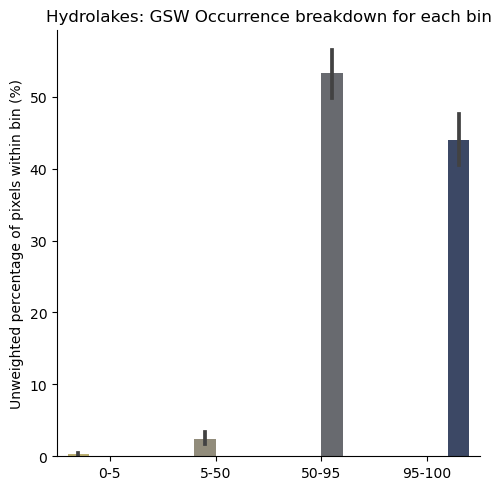

In [ ]:
## Plot
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(gdf_join_binned[['Hylak_id']+bin_labels].melt(id_vars='Hylak_id', var_name='Occurrence bin'),\
     hue = 'Occurrence bin', y='value', x='Occurrence bin', kind='bar', palette='cividis_r', errorbar=('ci', 95))
g.set_axis_labels('', 'Unweighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

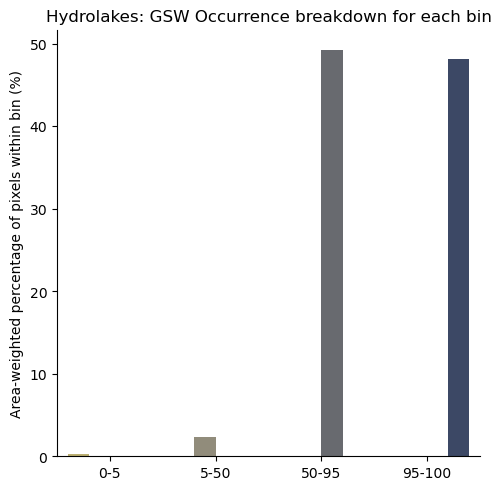

In [ ]:
## Weighted average histogram/barplot
dfWA = pd.DataFrame([weightAvg, bin_labels], index=['value','bin']).T
g = sns.catplot(dfWA, hue = 'bin', y='value', x='bin', kind='bar', palette='cividis_r')
g.set_axis_labels('', 'Area-weighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

In [ ]:
## TODO: add sns 95% CI by converting percentages to km2, summing, then normalizing

Text(0, 0.5, 'Unweighted percentage of pixels within bin (%)')

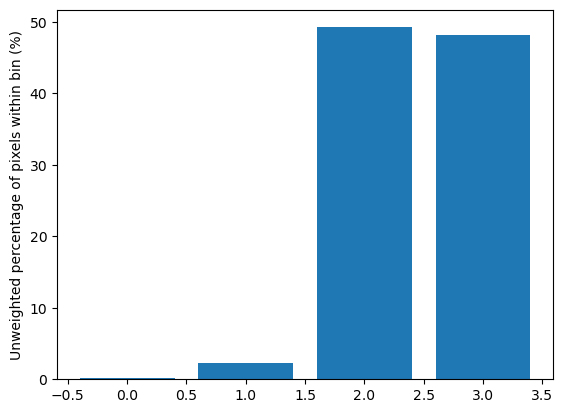

In [ ]:
## Weighted average histogram/barplot (alternate using MPL)

plt.bar(x=np.arange(4), height=weightAvg)
plt.ylabel( 'Unweighted percentage of pixels within bin (%)')


## ERRORS

```python
Computing (Hi Ethan!)... 
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
HttpError                                 Traceback (most recent call last)
File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py:328, in _execute_cloud_call(call, num_retries)
    327 try:
--> 328   return call.execute(num_retries=num_retries)
    329 except googleapiclient.errors.HttpError as e:

File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py:130, in positional.<locals>.positional_decorator.<locals>.positional_wrapper(*args, **kwargs)
    129         logger.warning(message)
--> 130 return wrapped(*args, **kwargs)

File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py:938, in HttpRequest.execute(self, http, num_retries)
    937 if resp.status >= 300:
--> 938     raise HttpError(resp, content, uri=self.uri)
    939 return self.postproc(resp, content)

HttpError: <HttpError 400 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "User memory limit exceeded.". Details: "User memory limit exceeded.">

During handling of the above exception, another exception occurred:

EEException                               Traceback (most recent call last)
File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py:6961, in zonal_stats_by_group(in_value_raster, in_zone_vector, out_file_path, statistics_type, decimal_places, denominator, scale, crs, tile_scale, return_fc, verbose, timeout, proxies, **kwargs)
   6960     else:
-> 6961         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6963 except Exception as e:
...
   6961         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6963 except Exception as e:
-> 6964     raise Exception(e)

Exception: User memory limit exceeded.

```python
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
RemoteTraceback                           Traceback (most recent call last)
RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 328, in _execute_cloud_call
    return call.execute(num_retries=num_retries)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py", line 938, in execute
    raise HttpError(resp, content, uri=self.uri)
googleapiclient.errors.HttpError: <HttpError 429 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.". Details: "Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.">

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/retry/api.py", line 73, in retry_decorator
    return __retry_internal(partial(f, *args, **kwargs), exceptions, tries, delay, max_delay, backoff, jitter,
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/retry/api.py", line 33, in __retry_internal
...
    772     return self._value
    773 else:
--> 774     raise self._value

EEException: Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.